template taken from https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/tree/main/4-Generative-deeplearning-with-tensorflow/week-2

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

import math
import os
import numpy as np
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
tfd = tfp.distributions

## Imports

In [ ]:
#@title Parameters
number_of_distributions =  1#@param {type:"integer"}
arch_type = "mlp" #@param ["mlp","cnn"]
dist_type = "t" #@param ["mse", "normal_without_cov", "normal_with_diag_cov", "normal", "t_without_cov", "t_with_diag_cov", "t", "nf", "matrix_mse", "matrix_normal_without_cov", "matrix_normal_with_diag_cov", "matrix_normal", "matrix_t_without_cov", "matrix_t_with_diag_cov", "matrix_t", "vae"]
dataset_name = "mnist" #@param ["mnist", "fashion_mnist"]

if dist_type in ['mse',"nf", "matrix_mse","vae"]:
  if number_of_distributions != 1:
    raise Exception("number of distributions must be 1 for "+dist_type)

if arch_type == "cnn":
  if dist_type not in ["matrix_mse", "matrix_normal_without_cov", "matrix_normal_with_diag_cov", "matrix_normal", "matrix_t_without_cov", "matrix_t_with_diag_cov", "matrix_t"]:
    raise Exception("arch type must be mlp for "+dist_type)

## Prepare the Dataset

In [ ]:
# Load the train and test sets from TFDS

OUTPUT_DIRECTORY = "."

OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
import os
if not os.path.exists(OUTPUT_DIRECTORY):
    os.mkdir(OUTPUT_DIRECTORY)
    print("Directory " , OUTPUT_DIRECTORY ,  " Created ")

TOLERANCE = 1e-6

UNITS = 32
ACTIVATION = 'relu'

N_EPOCHS = 20
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset, ds_info = tfds.load(dataset_name, as_supervised=True, split="train", with_info=True)
SHAPE = ds_info.features['image'].shape
DIMENSIONALITY = np.prod(SHAPE)
NTRAIN = ds_info.splits['train'].num_examples

def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  in_image = tf.reshape(image, shape=(DIMENSIONALITY,))

  if arch_type == "mlp":
    if "matrix" in dist_type:
      return in_image, tf.squeeze(image) ##############################################################################################################
    return in_image,in_image
  elif arch_type == "cnn":
    return image, tf.squeeze(image)

train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load(dataset_name, as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Directory  C:\Users\Sebi\Desktop\paper-june\results\1-mlp-t-mnist  Created 


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

In [ ]:
    def simple_autoencoder(inputs):
      global UNITS
      '''Builds the encoder and decoder using Dense layers.'''
      d = DIMENSIONALITY
      k = number_of_distributions

      if arch_type == "mlp":
        if dist_type == "mse":
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=d)(encoder)
        elif dist_type == "normal_without_cov":
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+d*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MultivariateNormalDiag(
              loc=t[..., i*d+k:(i+1)*d+k],
              scale_diag=[1.0 for j in range(d)]) for i in range(k)]),  
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "normal_with_diag_cov":
          #   encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          #   decoder = tf.keras.layers.Dense(units=2*d)(encoder)
          #   # decoder = tfpl.MultivariateNormalTriL(d)
          #   decoder = tfpl.DistributionLambda(
          #     make_distribution_fn=lambda t: tfd.MultivariateNormalDiag(
          #         loc=(t[..., :d]), 
          #         # scale_diag=[1.0 for i in range(d)]),#0.0001+tf.math.softplus(t[..., d:])),
          #         scale_diag=(1e-6)+tf.math.softplus(t[..., d:])),
          #     convert_to_tensor_fn=lambda s: tf.clip_by_value(
          #     tf.linalg.diag_part(s.covariance()), clip_value_min=0.0, clip_value_max=1.0, name=None
          # )
          #   )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+2*d*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MultivariateNormalDiag(
              loc=t[..., i*d+k:(i+1)*d+k],
              scale_diag=TOLERANCE + tf.math.softplus(t[..., i*d+k+d*k:(i+1)*d+k+d*k])) for i in range(k)]),  
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "normal":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=tfpl.MultivariateNormalTriL.params_size(d))(encoder)
          # # decoder = tfpl.MultivariateNormalTriL(d)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MultivariateNormalTriL(
          #       loc=(t[..., :d]), 
          #       scale_tril=tfb.FillScaleTriL().forward(t[..., d:])),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(),clip_value_min=0.0, clip_value_max=1.0, name=None)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+d*k+d*(d+1)/2*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MultivariateNormalTriL(
              loc=t[..., i*d+k:(i+1)*d+k],
              scale_tril=tfb.FillScaleTriL().forward(t[..., i*int(d*(d+1)/2)+k+d*k:(i+1)*int(d*(d+1)/2)+k+d*k])) for i in range(k)]),  
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "t_without_cov":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=1+d)(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MultivariateStudentTLinearOperator(
          #       df=1e-6+tf.math.softplus(t[...,0]),
          #       loc=t[..., 1:(d+1)], 
          #       scale=tf.linalg.LinearOperatorDiag([1.0 for i in range(d)))],
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(),clip_value_min=0.0, clip_value_max=1.0, name=None)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+k+d*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MultivariateStudentTLinearOperator(
              df=TOLERANCE+tf.math.softplus(t[...,k+i]),
              loc=t[..., k+i*d+k:k+(i+1)*d+k],
              scale=tf.linalg.LinearOperatorDiag([1.0 for j in range(d)])) for i in range(k)])
          )(decoder)
        elif dist_type == "t_with_diag_cov":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=1+d+d)(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MultivariateStudentTLinearOperator(
          #       df=1e-6+tf.math.softplus(t[...,0]),
          #       loc=t[..., 1:(d+1)], 
          #       scale=tf.linalg.LinearOperatorDiag(1e-6+tf.math.softplus(t[...,(d+1):]))),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(),clip_value_min=0.0, clip_value_max=1.0, name=None)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+k+2*d*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MultivariateStudentTLinearOperator(
              df=TOLERANCE+tf.math.softplus(t[...,k+i]),
              loc=t[..., k+i*d+k:k+(i+1)*d+k],
              scale=tf.linalg.LinearOperatorDiag(TOLERANCE + tf.math.softplus(t[..., d*k+k+i*d+k:d*k+k+(i+1)*d+k]))) for i in range(k)])
          )(decoder)
        elif dist_type == "t":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=1+d+int(d*(d+1)/2))(encoder)
          # # decoder = tfpl.MultivariateNormalTriL(d)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MultivariateStudentTLinearOperator(
          #       df=1e-6+tf.math.softplus(t[...,0]),
          #       loc=t[..., 1:(d+1)], 
          #       scale=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., (d+1):]))),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(),clip_value_min=0.0, clip_value_max=1.0, name=None) # mode because men is defined only when df>1
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+k+d*k+d*(d+1)/2*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MultivariateStudentTLinearOperator(
              df=TOLERANCE+tf.math.softplus(t[...,k+i]),
              loc=t[..., k+i*d+k:k+(i+1)*d+k],
              scale=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., k+k+d*k+int(d*(d+1)/2)*i:k+k+d*k+int(d*(d+1)/2)*(i+1)]))) for i in range(k)])
          )(decoder)
        elif dist_type == "nf":
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=d)(encoder)
          decoder = tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
                loc=t,
                scale_diag=[1. for _ in range(d)]))(decoder)
          decoder = tfpl.AutoregressiveTransform(tfb.AutoregressiveNetwork(
                params=2, hidden_units=[10], activation=ACTIVATION),
                convert_to_tensor_fn=lambda s: tf.clip_by_value(s.sample(), clip_value_min=0.0, clip_value_max=1.0, name=None),
                )(decoder) # output not deterministic still!!!
        elif dist_type == "matrix_mse":
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=d)(encoder)
          decoder = tf.keras.layers.Reshape((SHAPE[0], SHAPE[1]))(decoder)
        elif dist_type == "matrix_normal_without_cov":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=d)(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MatrixNormalLinearOperator(
          #     loc=tf.reshape(t[...,:d],[-1,SHAPE[0],SHAPE[1]]),
          #     scale_row=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[0])]),
          #     scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[1])])),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+d*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MatrixNormalLinearOperator(
              loc=tf.reshape(t[...,i*d+k:(i+1)*d+k],[-1,SHAPE[0],SHAPE[1]]), 
              scale_row=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[0])]),
              scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[1])])) for i in range(k)]),  
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_normal_with_diag_cov":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=d+SHAPE[0]+SHAPE[1])(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MatrixNormalLinearOperator(
          #     loc=tf.reshape(t[...,:d],[-1,SHAPE[0],SHAPE[1]]),
          #     scale_row=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[...,d:(d+SHAPE[0])])),
          #     scale_column=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[...,(d+SHAPE[0]):(d+SHAPE[0]+SHAPE[1])]))),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+d*k+SHAPE[0]*k+SHAPE[1]*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MatrixNormalLinearOperator(
                loc=tf.reshape(t[...,i*d+k:(i+1)*d+k],[-1,SHAPE[0],SHAPE[1]]), 
                scale_row=tf.linalg.LinearOperatorDiag(TOLERANCE + tf.math.softplus(t[...,k*d+k+SHAPE[0]*i:k*d+k+SHAPE[0]*(i+1)])),
                scale_column=tf.linalg.LinearOperatorDiag(TOLERANCE + tf.math.softplus(t[...,k*d+k+SHAPE[0]*k+SHAPE[1]*i:k*d+k+SHAPE[0]*k+SHAPE[1]*(i+1)]))) for i in range(k)]),  
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_normal":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=d+SHAPE[0]*(SHAPE[0]+1)/2+SHAPE[1]*(SHAPE[1]+1)/2)(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MatrixNormalLinearOperator(
          #     loc=tf.reshape(t[...,:d],[-1,SHAPE[0],SHAPE[1]]),
          #     scale_row=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., d:int(d+SHAPE[0]*(SHAPE[1])/2)])),
          #     scale_column=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,int(d+SHAPE[0]*(SHAPE[1])/2):]))),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+d*k+SHAPE[0]*(SHAPE[0]+1)/2*k+SHAPE[1]*(SHAPE[1]+1)/2*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MatrixNormalLinearOperator(
                loc=tf.reshape(t[...,i*d+k:(i+1)*d+k],[-1,SHAPE[0],SHAPE[1]]), 
                scale_row=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*i:k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*(i+1)])),
                scale_column=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*k+int(SHAPE[1]*(SHAPE[1]+1)/2)*i:k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*k+int(SHAPE[1]*(SHAPE[1]+1)/2)*(i+1)]))) for i in range(k)]),  
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_t_without_cov":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=1+d)(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MatrixTLinearOperator(
          #     df=1e-6+tf.math.softplus(t[...,0]),
          #     loc=tf.reshape(t[...,1:(d+1)],[-1,SHAPE[0],SHAPE[1]]),
          #     scale_row=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[0])]),
          #     scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[1])])),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(), clip_value_min=0.0, clip_value_max=1.0)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+k+d*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MatrixTLinearOperator(
              df=TOLERANCE+tf.math.softplus(t[...,k+i]),
              loc=tf.reshape(t[...,i*d+k+k:(i+1)*d+k+k],[-1,SHAPE[0],SHAPE[1]]), 
              scale_row=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[0])]),
              scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[1])])) for i in range(k)])
          )(decoder)
        elif dist_type == "matrix_t_with_diag_cov":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=1+d+SHAPE[0]+SHAPE[1])(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MatrixTLinearOperator(
          #     df=1e-6+tf.math.softplus(t[...,0]),
          #     loc=tf.reshape(t[...,1:(d+1)],[-1,SHAPE[0],SHAPE[1]]),
          #     scale_row=tf.linalg.LinearOperatorDiag(
          #         (1e-6)+tf.math.softplus(t[...,(d+1):(d+1+SHAPE[0])])),
          #     scale_column=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[...,(d+1+SHAPE[0]):]))),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(), clip_value_min=0.0, clip_value_max=1.0)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+k+d*k+SHAPE[0]*k+SHAPE[1]*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MatrixTLinearOperator(
                df=TOLERANCE+tf.math.softplus(t[...,k+i]),
                loc=tf.reshape(t[...,i*d+k+k:(i+1)*d+k+k],[-1,SHAPE[0],SHAPE[1]]), 
                scale_row=tf.linalg.LinearOperatorDiag(TOLERANCE + tf.math.softplus(t[...,k+k*d+k+SHAPE[0]*i:k+k*d+k+SHAPE[0]*(i+1)])),
                scale_column=tf.linalg.LinearOperatorDiag(TOLERANCE + tf.math.softplus(t[...,k+k*d+k+SHAPE[0]*k+SHAPE[1]*i:k+k*d+k+SHAPE[0]*k+SHAPE[1]*(i+1)]))) for i in range(k)])
          )(decoder)
        elif dist_type == "matrix_t":
          # encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          # decoder = tf.keras.layers.Dense(units=d+1+SHAPE[0]*(SHAPE[0]+1)/2+SHAPE[1]*(SHAPE[1]+1)/2)(encoder)
          # decoder = tfpl.DistributionLambda(
          #   make_distribution_fn=lambda t: tfd.MatrixTLinearOperator(
          #       df=1e-6+tf.math.softplus(t[...,0]),
          #     loc=tf.reshape(t[...,1:(d+1)],[-1,SHAPE[0],SHAPE[1]]),
          #     scale_row=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., (d+1):int(1+d+SHAPE[0]*(SHAPE[0]+1)/2)])),
          #     scale_column=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,int(d+1+SHAPE[0]*(SHAPE[0]+1)/2):]))),
          #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(), clip_value_min=0.0, clip_value_max=1.0)
          # )(decoder)
          encoder = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION)(inputs)
          decoder = tf.keras.layers.Dense(units=k+k+d*k+SHAPE[0]*(SHAPE[0]+1)/2*k+SHAPE[1]*(SHAPE[1]+1)/2*k)(encoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
            cat=tfd.Categorical(
                probs=tf.nn.softmax(t[..., :k])),
            components=[tfd.MatrixTLinearOperator(
                df=TOLERANCE+tf.math.softplus(t[...,k+i]),
                loc=tf.reshape(t[...,i*d+k+k:(i+1)*d+k+k],[-1,SHAPE[0],SHAPE[1]]), 
                scale_row=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., k+k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*i:k+k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*(i+1)])),
                scale_column=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., k+k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*k+int(SHAPE[1]*(SHAPE[1]+1)/2)*i:k+k+d*k+int(SHAPE[0]*(SHAPE[0]+1)/2)*k+int(SHAPE[1]*(SHAPE[1]+1)/2)*(i+1)]))) for i in range(k)])
          )(decoder)
        elif dist_type == "vae":
          prior = tfd.Independent(tfd.Normal(loc=tf.zeros(UNITS), scale=1),
                              reinterpreted_batch_ndims=1)

          encoder = tfkl.Dense(tfpl.IndependentNormal.params_size(UNITS),activation=ACTIVATION)(inputs)
          decoder = tfpl.IndependentNormal(
              UNITS,
              activity_regularizer=tfpl.KLDivergenceRegularizer(prior))(encoder)
          decoder = tfkl.Dense(tfpl.IndependentNormal.params_size(DIMENSIONALITY))(decoder)
          decoder = tfpl.IndependentNormal(DIMENSIONALITY,
                                          convert_to_tensor_fn=tfp.distributions.Distribution.mean)(decoder)
      elif arch_type == "cnn":
        UNITS *= 10
        if dist_type == "matrix_mse":
          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding='same')(encoder)
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
        elif dist_type == "matrix_normal_without_cov":
          n_params_needed = k + k * SHAPE[0] * SHAPE[1]
          n_filters = math.ceil(n_params_needed/(SHAPE[0]*SHAPE[1])) # some parameters will be extra

          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(encoder) 
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
          decoder = tf.keras.layers.Flatten()(decoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
              cat=tfd.Categorical(
                  probs=tf.nn.softmax(t[...,:k])
              ),
              components=[tfd.MatrixNormalLinearOperator(
                loc=tf.reshape(t[...,k+SHAPE[0]*SHAPE[1]*i:k+SHAPE[0]*SHAPE[1]*(i+1)],[-1,SHAPE[0],SHAPE[1]]),
                scale_row=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[0])]),
                scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[1])])) for i in range(k)]),  # And same here.,
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_normal_with_diag_cov":
          n_params_needed = k + k * SHAPE[0] * SHAPE[1] + k * SHAPE[0] + k * SHAPE[1]
          n_filters = math.ceil(n_params_needed/(SHAPE[0]*SHAPE[1])) # some parameters will be extra

          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(encoder) 
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
          decoder = tf.keras.layers.Flatten()(decoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
              cat=tfd.Categorical(
                  probs=tf.nn.softmax(t[...,:k])
              ),
              components=[tfd.MatrixNormalLinearOperator(
                loc=tf.reshape(t[...,k+SHAPE[0]*SHAPE[1]*i:k+SHAPE[0]*SHAPE[1]*(i+1)],[-1,SHAPE[0],SHAPE[1]]),
                scale_row=tf.linalg.LinearOperatorDiag(
                    TOLERANCE + tf.math.softplus(t[...,k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*i:k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(i+1)])
                ),
                scale_column=tf.linalg.LinearOperatorDiag(
                    TOLERANCE + tf.math.softplus(t[...,k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*k+SHAPE[1]*i:k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*k+SHAPE[1]*(i+1)])
                )) for i in range(k)]),  # And same here.,
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_normal":
          n_params_needed = k + k * SHAPE[0] * SHAPE[1] + k * SHAPE[0]*(SHAPE[0]+1)//2 + k * SHAPE[1]*(SHAPE[1]+1)//2
          n_filters = math.ceil(n_params_needed/(SHAPE[0]*SHAPE[1])) # some parameters will be extra

          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3),  padding='same')(encoder) 
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
          decoder = tf.keras.layers.Flatten()(decoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
              cat=tfd.Categorical(
                  probs=tf.nn.softmax(t[...,:k])
              ),
              components=[tfd.MatrixNormalLinearOperator(
                loc=tf.reshape(t[...,k+SHAPE[0]*SHAPE[1]*i:k+SHAPE[0]*SHAPE[1]*(i+1)],[-1,SHAPE[0],SHAPE[1]]),
                scale_row=tf.linalg.LinearOperatorLowerTriangular(
                    tfb.FillScaleTriL().forward(t[...,k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*i:k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*(i+1)])
                ),
                scale_column=tf.linalg.LinearOperatorLowerTriangular(
                    tfb.FillScaleTriL().forward(t[...,k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*k+SHAPE[1]*(SHAPE[1]+1)//2*i:k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*k+SHAPE[0]*(SHAPE[0]+1)//2*(i+1)])
                )) for i in range(k)]),  # And same here.,
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_t_without_cov":
          n_params_needed = k + k + k * SHAPE[0] * SHAPE[1]
          n_filters = math.ceil(n_params_needed/(SHAPE[0]*SHAPE[1])) # some parameters will be extra

          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3),  padding='same')(encoder) 
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
          decoder = tf.keras.layers.Flatten()(decoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
              cat=tfd.Categorical(
                  probs=tf.nn.softmax(t[...,:k])
              ),
              components=[tfd.MatrixTLinearOperator(
                df=TOLERANCE + tf.math.softplus(t[...,k+i]),
                loc=tf.reshape(t[...,k+k+SHAPE[0]*SHAPE[1]*i:k+k+SHAPE[0]*SHAPE[1]*(i+1)],[-1,SHAPE[0],SHAPE[1]]),
                scale_row=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[0])]),
                scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(SHAPE[1])])) for i in range(k)]),  # And same here.,
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_t_with_diag_cov":
          n_params_needed = k + k + k * SHAPE[0] * SHAPE[1] + k * SHAPE[0] + k * SHAPE[1]
          n_filters = math.ceil(n_params_needed/(SHAPE[0]*SHAPE[1])) # some parameters will be extra

          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(encoder) 
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
          decoder = tf.keras.layers.Flatten()(decoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
              cat=tfd.Categorical(
                  probs=tf.nn.softmax(t[...,:k])
              ),
              components=[tfd.MatrixTLinearOperator(
                df=TOLERANCE + tf.math.softplus(t[...,k+i]),
                loc=tf.reshape(t[...,k+k+SHAPE[0]*SHAPE[1]*i:k+k+SHAPE[0]*SHAPE[1]*(i+1)],[-1,SHAPE[0],SHAPE[1]]),
                scale_row=tf.linalg.LinearOperatorDiag(
                    TOLERANCE + tf.math.softplus(t[...,k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*i:k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(i+1)])
                ),
                scale_column=tf.linalg.LinearOperatorDiag(
                    TOLERANCE + tf.math.softplus(t[...,k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*k+SHAPE[1]*i:k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*k+SHAPE[1]*(i+1)])
                )) for i in range(k)]),  # And same here.,
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
        elif dist_type == "matrix_t":
          n_params_needed = k + k + k * SHAPE[0] * SHAPE[1] + k * SHAPE[0]*(SHAPE[0]+1)//2 + k * SHAPE[1]*(SHAPE[1]+1)//2
          n_filters = math.ceil(n_params_needed/(SHAPE[0]*SHAPE[1])) # some parameters will be extra

          encoder = tf.keras.layers.Conv2D(filters=UNITS, kernel_size=(3,3), activation=ACTIVATION, padding='same')(inputs)
          encoder = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
          decoder = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(encoder) 
          decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
          decoder = tf.keras.layers.Flatten()(decoder)
          decoder = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Mixture(
              cat=tfd.Categorical(
                  probs=tf.nn.softmax(t[...,:k])
              ),
              components=[tfd.MatrixTLinearOperator(
                df=TOLERANCE + tf.math.softplus(t[...,k+i]),
                loc=tf.reshape(t[...,k+k+SHAPE[0]*SHAPE[1]*i:k+k+SHAPE[0]*SHAPE[1]*(i+1)],[-1,SHAPE[0],SHAPE[1]]),
                scale_row=tf.linalg.LinearOperatorLowerTriangular(
                    tfb.FillScaleTriL().forward(t[...,k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*i:k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*(i+1)])
                ),
                scale_column=tf.linalg.LinearOperatorLowerTriangular(
                    tfb.FillScaleTriL().forward(t[...,k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*k+SHAPE[1]*(SHAPE[1]+1)//2*i:k+k+SHAPE[0]*SHAPE[1]*k+SHAPE[0]*(SHAPE[0]+1)//2*k+SHAPE[0]*(SHAPE[0]+1)//2*(i+1)])
                )) for i in range(k)]),  # And same here.,
            convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
          )(decoder)
              

            

            
            
            

            





      # k=10
      # encoder = tf.keras.layers.Dense(units=32, activation=ACTIVATION)(inputs)
      # decoder = tf.keras.layers.Dense(units=k+d*k)(encoder)
      # decoder = tfpl.DistributionLambda(
      #   make_distribution_fn=lambda t: tfd.Mixture(
      #   cat=tfd.Categorical(
      #       probs=tf.nn.softmax(t[..., :k])),
      #   components=[tfd.MultivariateNormalTriL(
      #     loc=tf.math.sigmoid(t[..., i*d+k:(i+1)*d+k]),       # One for each component.
      #     scale_tril=tf.eye(d)) for i in range(k)]),  # And same here.,
      #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0, name=None)
      # )(decoder)


      

      

      ##V2
      # encoder = tf.keras.layers.Dense(units=32, activation=ACTIVATION)(inputs)
      # decoder = tf.keras.layers.Dense(units=d+28*29/2+28)(encoder)
      # decoder = tfpl.DistributionLambda(
      #   make_distribution_fn=lambda t: tfd.MatrixNormalLinearOperator(
      #     loc=tf.reshape(t[...,:d],[-1,28,28]),
      #     scale_row=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., d:(d+int(28*29/2))])),
      #     scale_column=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[...,(d+int(28*29/2)):]))),#tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,(d+int(28*27/2)):]))),# scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(28)])),
      #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
      # )(decoder)

      ##V3
      # encoder = tf.keras.layers.Dense(units=32, activation=ACTIVATION)(inputs)
      # decoder = tf.keras.layers.Dense(units=d+28+28*29/2)(encoder)
      # decoder = tfpl.DistributionLambda(
      #   make_distribution_fn=lambda t: tfd.MatrixNormalLinearOperator(
      #     loc=tf.reshape(t[...,:d],[-1,28,28]),
      #     scale_row=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[..., d:(d+28)])),
      #     scale_column=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,(d+28):]))),#tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,(d+int(28*27/2)):]))),# scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(28)])),
      #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mean(), clip_value_min=0.0, clip_value_max=1.0)
      # )(decoder)



      ##V2 matrix t
      # encoder = tf.keras.layers.Dense(units=32, activation=ACTIVATION)(inputs)
      # decoder = tf.keras.layers.Dense(units=1+d+28*29/2+28)(encoder)
      # decoder = tfpl.DistributionLambda(
      #   make_distribution_fn=lambda t: tfd.MatrixTLinearOperator(
      #     df=1e-6+tf.math.softplus(t[...,0]),
      #     loc=tf.reshape(t[...,1:(d+1)],[-1,28,28]),
      #     scale_row=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[..., (d+1):(d+1+int(28*29/2))])),
      #     scale_column=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[...,(d+1+int(28*29/2)):]))),#tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,(d+int(28*27/2)):]))),# scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(28)])),
      #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(), clip_value_min=0.0, clip_value_max=1.0)
      # )(decoder)

      ##V3 matrix t
      # encoder = tf.keras.layers.Dense(units=32, activation=ACTIVATION)(inputs)
      # decoder = tf.keras.layers.Dense(units=1+d+28+28*29/2)(encoder)
      # decoder = tfpl.DistributionLambda(
      #   make_distribution_fn=lambda t: tfd.MatrixTLinearOperator(
      #     df=1e-6+tf.math.softplus(t[...,0]),
      #     loc=tf.reshape(t[...,1:(1+d)],[-1,28,28]),
      #     scale_row=tf.linalg.LinearOperatorDiag((1e-6)+tf.math.softplus(t[..., (1+d):(d+1+28)])),
      #     scale_column=tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,(d+1+28):]))),#tf.linalg.LinearOperatorLowerTriangular(tfb.FillScaleTriL().forward(t[...,(d+int(28*27/2)):]))),# scale_column=tf.linalg.LinearOperatorDiag([1.0 for _ in range(28)])),
      #   convert_to_tensor_fn=lambda s: tf.clip_by_value(s.mode(), clip_value_min=0.0, clip_value_max=1.0)
      # )(decoder)


      

      # #FASTER even than a mixture with 1 component! - not valable anymore
      # encoder = tf.keras.layers.Dense(units=32, activation=ACTIVATION)(inputs)
      # decoder = tf.keras.layers.Dense(units=d)(encoder)
      # decoder = tfpl.DistributionLambda(
      #   make_distribution_fn=lambda t: tfd.MultivariateNormalFullCovariance(
      #       loc=tf.math.sigmoid(t[..., :d]), 
      #       covariance_matrix=tf.eye(d)),
      #   convert_to_tensor_fn=lambda s: s.mean()
      # )(decoder)

      return encoder, decoder


In [ ]:
    # set the input shape
    if arch_type == "cnn":
      inputs =  tf.keras.layers.Input(shape=SHAPE)
    elif arch_type == "mlp":
      inputs =  tf.keras.layers.Input(shape=(DIMENSIONALITY,))

    # get the encoder and decoder output
    encoder_output, decoder_output = simple_autoencoder(inputs)

    # setup the encoder because you will visualize its output later
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

    # setup the autoencoder
    autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

## Compile the Model

In [ ]:
if "mse" in dist_type:
  autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='mse')
else:
  autoencoder_model.compile(
      optimizer=tf.keras.optimizers.Adam(), 
      loss=lambda y, model: -model.log_prob(y))

## Train the Model

In [ ]:
# from https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [ ]:
train_steps = NTRAIN // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=N_EPOCHS, callbacks=[time_callback])

Epoch 1/20
468/468 [==============================] - 60s 121ms/step - loss: -901.6412
Epoch 2/20
468/468 [==============================] - 57s 121ms/step - loss: -1198.1125
Epoch 3/20
468/468 [==============================] - 57s 121ms/step - loss: -1337.5786
Epoch 4/20
468/468 [==============================] - 57s 122ms/step - loss: -1429.2495
Epoch 5/20
468/468 [==============================] - 57s 122ms/step - loss: -1511.6201
Epoch 6/20
468/468 [==============================] - 58s 123ms/step - loss: -1573.4664
Epoch 7/20
468/468 [==============================] - 58s 124ms/step - loss: -1628.8066
Epoch 8/20
468/468 [==============================] - 58s 124ms/step - loss: -1674.3402
Epoch 9/20
468/468 [==============================] - 58s 124ms/step - loss: -1718.8181
Epoch 10/20
468/468 [==============================] - 58s 124ms/step - loss: -1751.6370
Epoch 11/20
468/468 [==============================] - 58s 124ms/step - loss: -1796.8914
Epoch 12/20
468/468 [==========

## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [ ]:
def display_one_row(disp_images, offset, shape=(SHAPE[0], SHAPE[1])):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  f=plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(SHAPE[0],SHAPE[1],))
  # display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 10, shape=(SHAPE[0],SHAPE[1],))
  f.suptitle(str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
  f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot1.pdf"))

In [ ]:
def get_mode_from_mm(mm):
  index = tf.argmax([mm.log_prob(mm.components[i].mode()) for i in range(len(mm.components))])
  result = []
  for i in range(len(index)):
    index_i = index[i]
    result.append(mm.components[index_i].mode()[i].numpy())
  return result

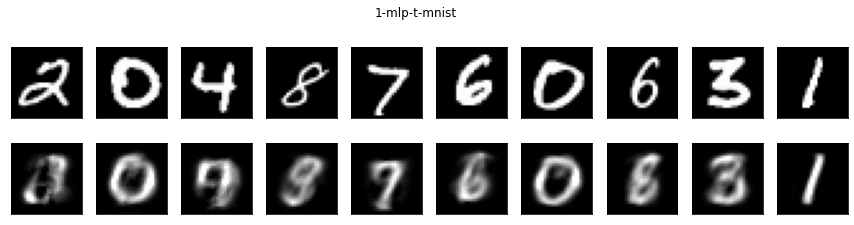

In [ ]:
    # take 1 batch of the dataset
    test_dataset = test_dataset.take(1)

    # take the input images and put them in a list
    output_samples = []
    for input_image, image in tfds.as_numpy(test_dataset):
          output_samples = input_image

    # pick 10 random numbers to be used as indices to the list above
    # idxs = np.random.choice(BATCH_SIZE, size=10)
    idxs = np.array(range(10))

    # get the encoder output
    encoded_predicted = encoder_model.predict(test_dataset)

    # get a prediction for the test batch
    if number_of_distributions == 1 and dist_type in ["normal_with_diag_cov", "normal", "t_with_diag_cov", "t", 
                                                      "matrix_normal_with_diag_cov", "matrix_normal", "matrix_t_with_diag_cov", "matrix_t"]:
      def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
        '''Displays the input, encoded, and decoded output values.'''
        f=plt.figure(figsize=(15, 5))
        display_one_row(disp_input_images, 0, shape=(SHAPE[0],SHAPE[1],))
        plt.title("orig. image")
        display_one_row(disp_encoded, 10, shape=(SHAPE[0],SHAPE[1]))
        plt.title("variance")
        display_one_row(disp_predicted, 20, shape=(SHAPE[0],SHAPE[1],))
        plt.title("mean/mode")
        f.suptitle(str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
        f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot1.pdf"))
      if dist_type in ["normal_with_diag_cov", "normal","matrix_normal_with_diag_cov", "matrix_normal"]:
        simple_predicted = tf.clip_by_value(autoencoder_model(output_samples[idxs]).components[0].mean(), clip_value_min=0.0, clip_value_max=1.0).numpy()
      elif dist_type in ["t_with_diag_cov", "t", "matrix_t_with_diag_cov", "matrix_t"]:
        simple_predicted = tf.clip_by_value(autoencoder_model(output_samples[idxs]).components[0].mode(), clip_value_min=0.0, clip_value_max=1.0).numpy()
      if dist_type in ["normal_with_diag_cov", "normal", "t_with_diag_cov", "t"]:
        simple_predicted_var = tf.clip_by_value(tf.linalg.diag_part(autoencoder_model(output_samples[idxs]).components[0].covariance()).numpy().reshape([-1,SHAPE[0],SHAPE[1]]), clip_value_min=0.0, clip_value_max=1.0).numpy()
      elif dist_type in ["matrix_normal_with_diag_cov", "matrix_normal", "matrix_t_with_diag_cov", "matrix_t"]:
        simple_predicted_var = np.zeros((output_samples.shape))
        for idx in idxs:
          row_vars = np.diag(autoencoder_model(output_samples[idx:idx+1]).components[0].scale_row.to_dense().numpy()[0])
          col_vars = np.diag(autoencoder_model(output_samples[idx:idx+1]).components[0].scale_column.to_dense().numpy()[0])
          M = np.zeros((SHAPE[0],SHAPE[1]))
          for i in range(SHAPE[0]):
            for j in range(SHAPE[1]):
              M[i,j] = row_vars[i] * col_vars[j]
              if M[i,j] > 1.0:
                M[i,j] = 1.0
              if M[i,j] < 0.0:
                M[i,j] = 0.0
          if arch_type == "mlp":
            simple_predicted_var[idx] = M.reshape((-1,SHAPE[0]*SHAPE[1]))
          elif arch_type == "cnn":
            simple_predicted_var[idx] = M[...,np.newaxis]
      display_results(output_samples[idxs], simple_predicted_var[idxs], simple_predicted[idxs])
    else:
      if dist_type == "nf":
        ##V2
        simple_predicted = np.random.random_sample((output_samples.shape))
        simple_predicted[idxs] = tf.clip_by_value(tf.math.reduce_mean(autoencoder_model(output_samples[idxs]).sample(50),axis=0), clip_value_min=0.0, clip_value_max=1.0).numpy()
      elif dist_type in ["t_without_cov", "t_with_diag_cov", "t"]:
        simple_predicted = np.random.random_sample((output_samples.shape))
        simple_predicted[idxs] = tf.clip_by_value(get_mode_from_mm(autoencoder_model(output_samples[idxs])), clip_value_min=0.0, clip_value_max=1.0).numpy()
      elif dist_type in ["matrix_t_without_cov", "matrix_t_with_diag_cov", "matrix_t"]:
        simple_predicted = np.random.random_sample((output_samples.shape[0], SHAPE[0],SHAPE[1]))
        simple_predicted[idxs] = tf.clip_by_value(get_mode_from_mm(autoencoder_model(output_samples[idxs])), clip_value_min=0.0, clip_value_max=1.0).numpy()
      else:
        ##V1
        simple_predicted = tf.clip_by_value(autoencoder_model.predict(test_dataset), clip_value_min=0.0, clip_value_max=1.0).numpy()

      # display the 10 samples, encodings and decoded values!
      display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])


In [ ]:
# from https://stackoverflow.com/questions/55421153/fr%C3%A9chet-inception-distance-parameters-choice-in-tensorflow
import numpy as np
import scipy.linalg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.compat.v1 import ConfigProto
from skimage.transform import resize

def scale_images(images, new_shape):
    return np.asarray([resize(image, new_shape, 0) for image in images])

def calculate_fid(model, images1, images2):
    f1, f2 = [model.predict(im) for im in (images1, images2)]
    mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
    mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
    sum_sq_diff = np.sum((mean1 - mean2)**2)
    cov_mean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
    return fid

def fid(dataset):
    input_shape = (299, 299, 3)

    inception = InceptionV3(include_top=False, pooling='avg', input_shape=input_shape)

    dataset = scale_images(dataset, input_shape)

    noise = preprocess_input(np.clip(255*np.random.uniform(size=dataset.shape), 0, 255))
    noise = scale_images(noise, input_shape)

    return calculate_fid(inception, dataset, noise)

In [ ]:
def get_data(dataset_name):
  import tensorflow as tf
  keras_dataset=getattr(tf.keras.datasets, dataset_name)
  (x_train, y_train),(x_test, y_test) = keras_dataset.load_data()
  if arch_type == "mlp":
    return ((x_train.reshape((x_train.shape[0],-1))/255.).astype(np.float32), y_train),((x_test.reshape((x_test.shape[0],-1))/255.).astype(np.float32),y_test)
  elif arch_type == "cnn":
    return ((x_train/255.).astype(np.float32), y_train),((x_test/255.).astype(np.float32),y_test)

In [ ]:
(X_train,y_train),(X_test,y_test) = get_data(dataset_name)

In [ ]:
fid_how_many = 1000

In [ ]:
    if dist_type == "nf":
      # X_test_autoenc=tf.clip_by_value(tf.math.reduce_mean(autoencoder_model(X_test[:fid_how_many]).sample(50),axis=0), clip_value_min=0.0, clip_value_max=1.0)
      X_test_autoenc = np.zeros((fid_how_many,)+X_test.shape[1:])
      step = 10
      for i in range(0,fid_how_many,step):
        print(i)
        X_test_autoenc[i:i+step] = tf.clip_by_value(tf.math.reduce_mean(autoencoder_model(X_test[i:i+step]).sample(50),axis=0), clip_value_min=0.0, clip_value_max=1.0).numpy()
    elif dist_type in ["t_without_cov", "t_with_diag_cov"]:
      X_test_autoenc=tf.clip_by_value(get_mode_from_mm(autoencoder_model(X_test[:fid_how_many])), clip_value_min=0.0, clip_value_max=1.0).numpy()
    elif dist_type == "t":
      # X_test_autoenc=tf.clip_by_value(get_mode_from_mm(autoencoder_model(X_test[:fid_how_many])), clip_value_min=0.0, clip_value_max=1.0).numpy()
      X_test_autoenc = np.zeros((fid_how_many,)+X_test.shape[1:])
      step = 10
      for i in range(0,fid_how_many,step):
        print(i)
        X_test_autoenc[i:i+step] = tf.clip_by_value(get_mode_from_mm(autoencoder_model(X_test[i:i+step])), clip_value_min=0.0, clip_value_max=1.0).numpy()
    elif dist_type in ["matrix_t_without_cov", "matrix_t_with_diag_cov", "matrix_t"]:
      X_test_autoenc=tf.clip_by_value(get_mode_from_mm(autoencoder_model(X_test[:fid_how_many])), clip_value_min=0.0, clip_value_max=1.0).numpy()
    else:
      X_test_autoenc=tf.clip_by_value(autoencoder_model.predict(X_test[:fid_how_many]), clip_value_min=0.0, clip_value_max=1.0).numpy()


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [ ]:
    import tensorflow as tf
    def l1_error(x,y,max_val=1.0):
      return tf.reduce_mean(tf.abs(x/max_val - y/max_val),axis=[1,2,3]).numpy() * 100.0

    def l2_error(x,y,max_val=1.0):
      return tf.reduce_mean((x/max_val - y/max_val) ** 2,axis=[1,2,3]).numpy() * 100.0

    # tf.image.psnr(x,y,max_val=1.0).numpy()

    # tf.image.ssim(x,y,max_val=1.0).numpy()

    aux_val1 = X_test[:fid_how_many].reshape((fid_how_many,SHAPE[0],SHAPE[1],1))
    aux_val2 = X_test_autoenc[:fid_how_many].reshape((fid_how_many,SHAPE[0],SHAPE[1],1))

    L1_ERRORS = l1_error(aux_val1,aux_val2,max_val=1.0)
    L2_ERRORS = l2_error(aux_val1,aux_val2,max_val=1.0)
    PSNR_ERRORS = tf.image.psnr(aux_val1,aux_val2,max_val=1.0).numpy()
    SSIM_ERRORS = tf.image.ssim(aux_val1.astype(np.float32),
                            aux_val2.astype(np.float32),max_val=1.0).numpy()

    # print(L1_ERRORS)
    # print(L2_ERRORS)
    # print(PSNR_ERRORS)
    # print(SSIM_ERRORS)

    file = open(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-text_ERRORS.txt"),"w")
    file.write(str(L1_ERRORS)+"\n")
    file.write(str(L2_ERRORS)+"\n")
    file.write(str(PSNR_ERRORS)+"\n")
    file.write(str(SSIM_ERRORS)+"\n")
    file.close()

    print(L1_ERRORS.mean())
    print(L2_ERRORS.mean())
    print(PSNR_ERRORS.mean())
    print(SSIM_ERRORS.mean())

    file = open(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-text_ERROR.txt"),"w")
    file.write(str(L1_ERRORS.mean())+"\n")
    file.write(str(L2_ERRORS.mean())+"\n")
    file.write(str(PSNR_ERRORS.mean())+"\n")
    file.write(str(SSIM_ERRORS.mean())+"\n")
    file.close()

In [ ]:
if dist_type == "mse":
  # just once
  value=fid(X_test[:fid_how_many].reshape((fid_how_many,SHAPE[0],SHAPE[1])))
  print(value)
  file = open(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-text1.txt"),"w")
  file.write(str(value))
  file.close()

In [ ]:
value=fid(X_test_autoenc[:fid_how_many].reshape((fid_how_many,SHAPE[0],SHAPE[1])))
print(value) # len(X_test_autoenc) == fid_how_many ...
file = open(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-text2.txt"),"w")
file.write(str(value))
file.close()

465.9395752555321


In [ ]:
value=autoencoder_model.count_params()
print(value)
# autoencoder_model.summary()
file = open(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-text3.txt"),"w")
file.write(str(value))
file.close()

10205818


In [ ]:
times = time_callback.times
value=np.average(times)
print(value,"seconds")
file = open(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-text4.txt"),"w")
file.write(str(value))
file.close()

57.78899344205856 seconds


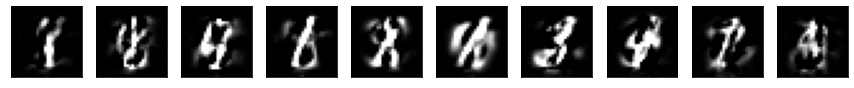

In [ ]:
N_RANDOM = 10
if dist_type == "vae":
  random_z = np.random.normal(size=(N_RANDOM,UNITS)).clip(0,None)
  decoder_model = tf.keras.Sequential(autoencoder_model.layers[3:])
elif arch_type == "cnn":
  random_z = np.random.normal(size=(N_RANDOM,)+encoder_model.output_shape[1:]).clip(0,None)
  decoder_model = tf.keras.Sequential(autoencoder_model.layers[3:])
else:
  random_z = np.random.normal(size=(N_RANDOM,)+encoder_model.output_shape[1:]).clip(0,None)
  decoder_model = tf.keras.Sequential(autoencoder_model.layers[2:])
random_output = decoder_model(random_z)

if dist_type == "nf":
  random_output=tf.clip_by_value(tf.math.reduce_mean(random_output.sample(50),axis=0), clip_value_min=0.0, clip_value_max=1.0).numpy()
elif dist_type in ["t_without_cov", "t_with_diag_cov", "t"]:
  random_output=tf.clip_by_value(get_mode_from_mm(random_output), clip_value_min=0.0, clip_value_max=1.0).numpy()
elif dist_type in ["matrix_t_without_cov", "matrix_t_with_diag_cov", "matrix_t"]:
  random_output=tf.clip_by_value(get_mode_from_mm(random_output), clip_value_min=0.0, clip_value_max=1.0).numpy()
else:
  random_output=tf.clip_by_value(random_output, clip_value_min=0.0, clip_value_max=1.0).numpy()

random_output=random_output.reshape((N_RANDOM,SHAPE[0],SHAPE[1]))

import matplotlib.pyplot as plt
f=plt.figure(figsize=(15,5))
for i in range(N_RANDOM):
  plt.subplot(1,N_RANDOM,i+1)  
  plt.xticks([])
  plt.yticks([])
  plt.imshow(random_output[i],cmap="gray")
plt.show()
f.suptitle(str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot2.pdf"))

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
if dist_type == "mse":
  # just once
  X_test_embedded = TSNE(n_components=2).fit_transform(X_test)

  import matplotlib.pyplot as plt
  from matplotlib.colors import ListedColormap
  from matplotlib import cm

  f=plt.figure(figsize=(16,10))
  scatter = plt.scatter(X_test_embedded[:,0], 
                        X_test_embedded[:,1],
                        c=y_test.tolist(),
                        alpha=0.5,
                        edgecolors="black", 
                        cmap='gist_ncar')
  plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(y_test).tolist())
  f.suptitle(dataset_name)
  f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot3.pdf"))

In [ ]:
X_test_enc = encoder_model(X_test).numpy().reshape((X_test.shape[0],-1))
X_test_enc_embedded = TSNE(n_components=2).fit_transform(X_test_enc)

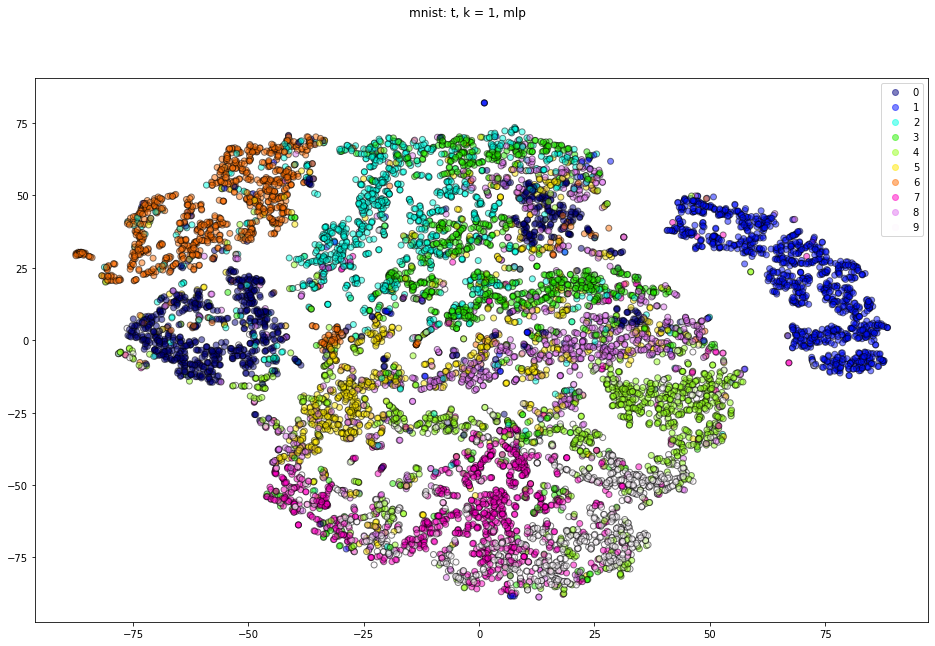

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

f=plt.figure(figsize=(16,10))
scatter = plt.scatter(X_test_enc_embedded[:,0], 
                      X_test_enc_embedded[:,1],
                      c=y_test.tolist(),
                      alpha=0.5,
                      edgecolors="black", 
                      cmap='gist_ncar')
plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(y_test).tolist())
f.suptitle(dataset_name + ": " + dist_type + ", k = "+str(number_of_distributions) +", "+arch_type)
f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot4.pdf"))

In [ ]:
# for batch in test_dataset.take(1):
#   pass

# index = 4

# import matplotlib.pyplot as plt

# # plt.figure()
# # plt.imshow(batch[0][index].numpy().reshape(SHAPE[0],SHAPE[1]),cmap="gray")
# # plt.show()

# # # print(autoencoder_model(batch[0]).cat.probs[index])

# # plt.figure()
# # plt.imshow(autoencoder_model(batch[0]).mean()[index].numpy().reshape(SHAPE[0],SHAPE[1]),cmap="gray")
# # plt.show()
# autoencoder_model(batch[0][index][tf.newaxis,...]).scale.to_dense()

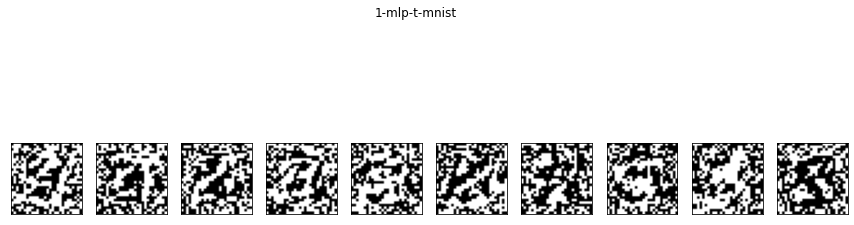

In [ ]:
for batch in test_dataset.take(1):
  pass

index = 0 #@param {type:"slider", min:0, max:100, step:1}

aux = autoencoder_model(batch[0][index].numpy()[np.newaxis,...])
if type(aux).__name__ == "_TensorCoercible":
  f=plt.figure(figsize=(15,5))
  for i in range(10):
    plt.subplot(1,10,i+1)  
    plt.xticks([])
    plt.yticks([])
    plt.imshow(aux.sample().numpy().reshape(SHAPE[0],SHAPE[1]).clip(0,1),cmap="gray")
  # plt.show()
  f.suptitle(str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
  f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot5.pdf"))

In [ ]:
if number_of_distributions > 1:

  import matplotlib.pyplot as plt

  f=plt.figure()
  plt.imshow(batch[0][index].numpy().reshape(SHAPE[0],SHAPE[1]),cmap="gray")
  plt.show()
  f.suptitle(str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
  f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot6.pdf"))

  print(autoencoder_model(batch[0]).cat.probs[index])

  f=plt.figure(figsize=(15,5))
  for i in range(len(autoencoder_model(batch[0]).components)):
    plt.subplot(1,len(autoencoder_model(batch[0]).components),i+1)  
    plt.xticks([])
    plt.yticks([])
    aux=autoencoder_model(batch[0]).components[i].mode()[index].numpy()
    # print(autoencoder_model(batch[0]).log_prob(aux)[index])
    plt.imshow(aux.reshape(SHAPE[0],SHAPE[1]),cmap="gray")
  plt.show()

  f.suptitle(str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name)
  f.savefig(os.path.join(OUTPUT_DIRECTORY, str(number_of_distributions) + "-" + arch_type + "-" + dist_type +"-" +dataset_name + "-plot7.pdf"))


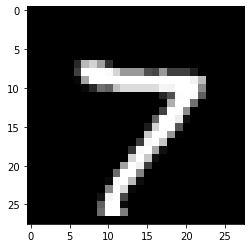

tf.Tensor(
[1.1293227e-05 5.3846580e-12 5.8032031e-11 3.9397634e-08 1.0002692e-06
 5.0722006e-06 2.2802299e-06 2.5137988e-04 4.1277206e-05 9.9968767e-01], shape=(10,), dtype=float32)


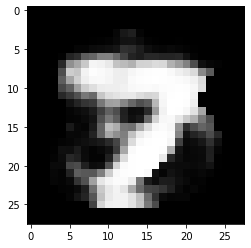

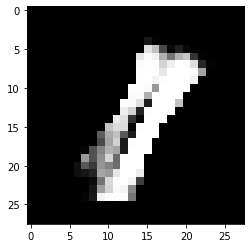

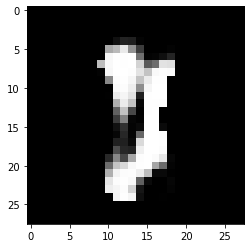

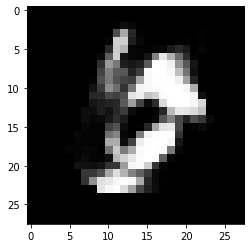

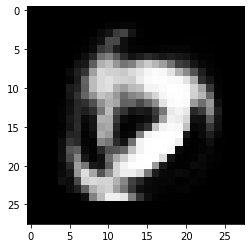

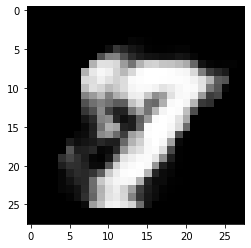

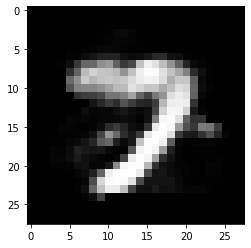

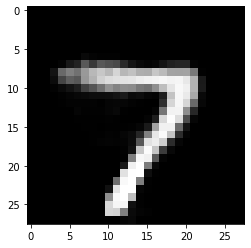

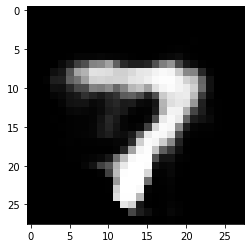

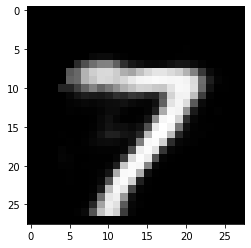

In [ ]:
# for batch in test_dataset.take(1):
#   pass

# index = 4

# import matplotlib.pyplot as plt

# plt.figure()
# plt.imshow(batch[0][index].numpy().reshape(SHAPE[0],SHAPE[1]),cmap="gray")
# plt.show()

# print(autoencoder_model(batch[0]).cat.probs[index])

# for i in range(len(autoencoder_model(batch[0]).components)):
#   plt.figure()
#   plt.imshow(autoencoder_model(batch[0]).components[i].mean()[index].numpy().reshape(SHAPE[0],SHAPE[1]),cmap="gray")
#   plt.show()